# Intel Image Classification

By Aviya Oren and Maya Hayat

This Data contains around 25k images of size 150x150 distributed under 6 categories.
1. 'buildings'
2. 'forest'
3. 'glacier'
4. 'mountain'
5. 'sea'
6. 'street'

In [92]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
import glob as gb
import numpy as np
import pandas as pd
import os
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import plotly.express as px
import seaborn as sns

from PIL import Image
from tqdm import tqdm
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

import cv2
import imghdr
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

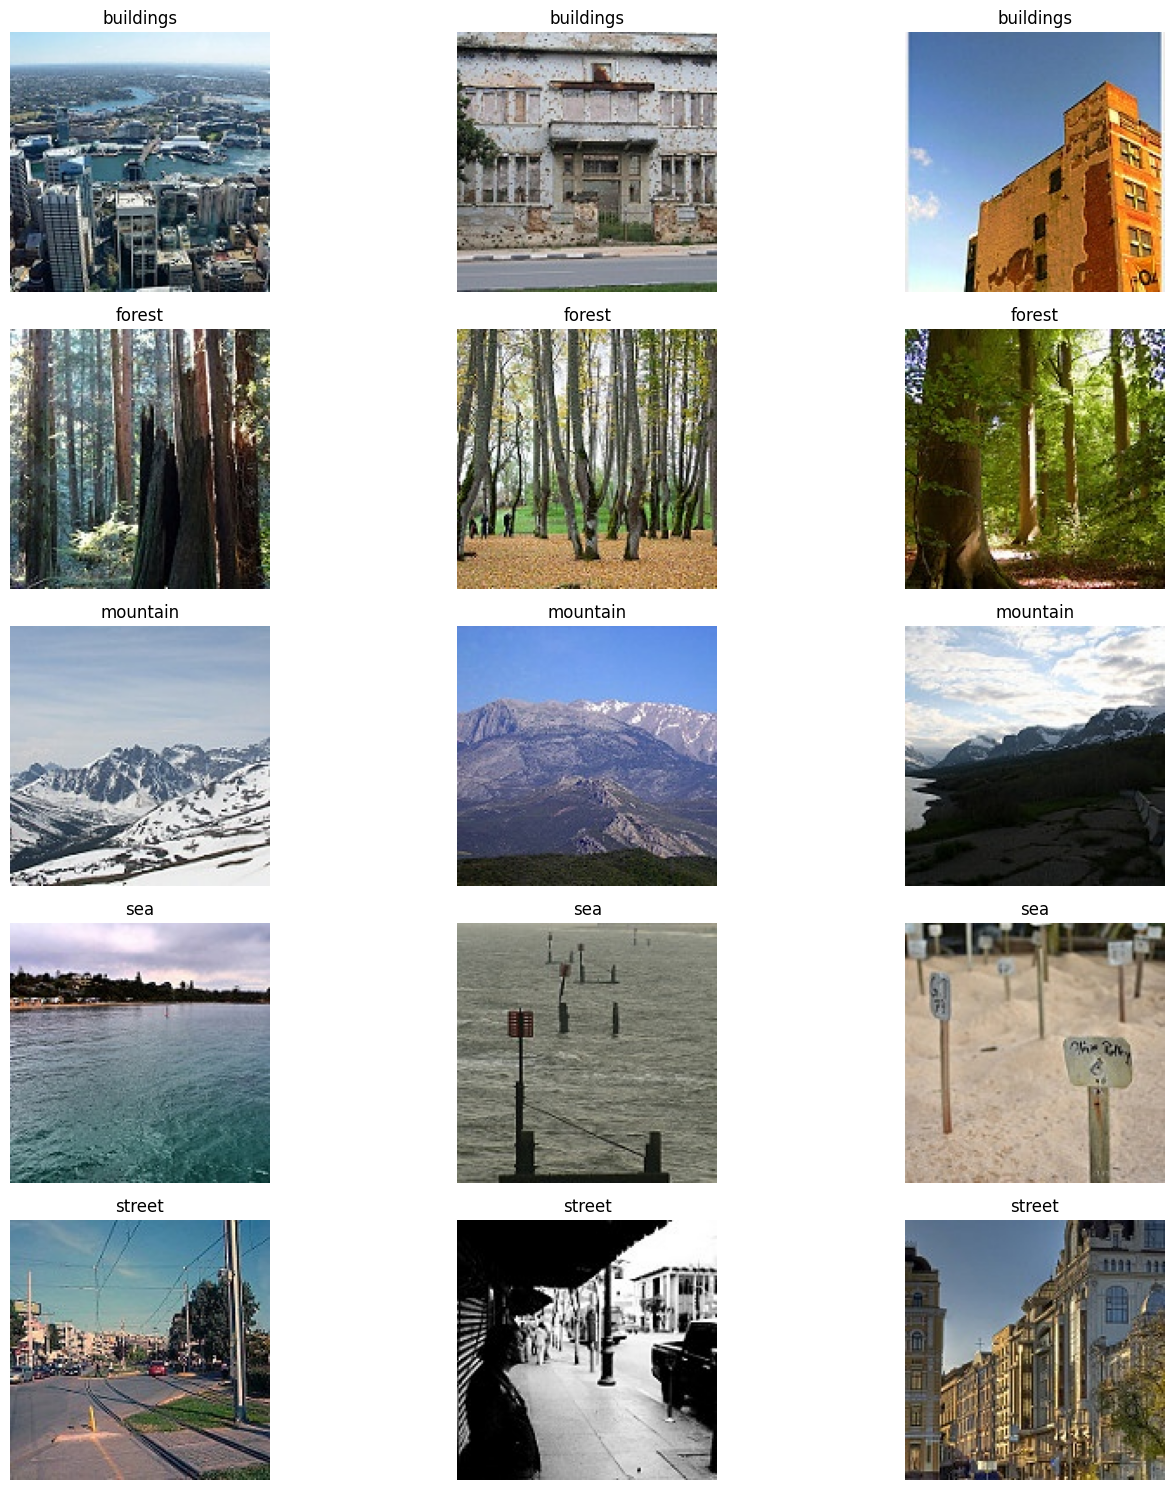

In [7]:
# Path to the directory containing the images
base_directory = 'seg_train/seg_train'

# Categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Display three random images for each category
fig, axs = plt.subplots(len(categories), 3, figsize=(15, 15))

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    random_images = random.sample(image_files, 3)

    for j, image_file in enumerate(random_images):
        image_path = os.path.join(category_directory, image_file)
        image = mpimg.imread(image_path)
        axs[i, j].imshow(image)
        axs[i, j].axis('off')
        axs[i, j].set_title(category)

plt.tight_layout()
plt.show()


In [8]:

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Traing files is {category} is number of items is === {len(image_files)}")

for Traing files is buildings is number of items is === 2191
for Traing files is forest is number of items is === 2271
for Traing files is mountain is number of items is === 2512
for Traing files is sea is number of items is === 2274
for Traing files is street is number of items is === 2382


In [9]:
test_directory = 'seg_test/seg_test'
for i, category in enumerate(categories):
    category_directory = os.path.join(test_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]
    print(f"for Testing files is {category} is number of items is === {len(image_files)}")

for Testing files is buildings is number of items is === 437
for Testing files is forest is number of items is === 474
for Testing files is mountain is number of items is === 525
for Testing files is sea is number of items is === 510
for Testing files is street is number of items is === 501


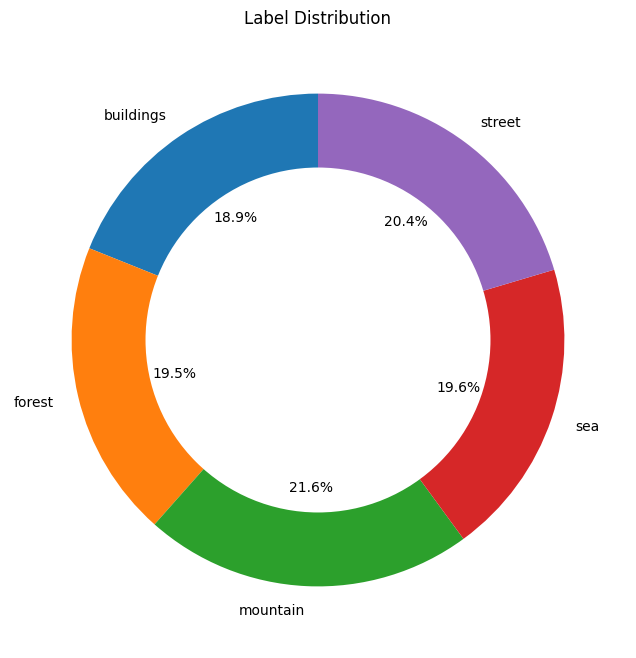

In [10]:
label_counts = {
    'buildings': 2211,
    'forest': 2281,
    'mountain': 2522,
    'sea': 2284,
    'street': 2382
}

labels = list(label_counts.keys())
sizes = list(label_counts.values())

# Plotting the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)

# Draw a circle at the center to make it a donut chart
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

plt.title('Label Distribution')
plt.show()

### Demi-model which randomly assign each image in the test set to one of the specified categories

In [105]:

# Define the categories
categories = ['buildings', 'forest', 'mountain', 'sea', 'street']

# Counters for correct predictions and total predictions
correct_predictions = 0
total_predictions = 0

# Iterate through subdirectories and test images
for category_folder in os.listdir(test_directory):
    category_path = os.path.join(test_directory, category_folder)

    # Check if the item is a directory
    if os.path.isdir(category_path):
        print(f"Category: {category_folder}")

        # Iterate through images in the category
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            predicted_category = random.choice(categories)

            # # Display result
            # print(f"Image: {image_name}")
            # print(f"Actual Category: {category_folder}")
            # print(f"Predicted Category: {predicted_category}")
            # print("\n")

            # Update counters
            total_predictions += 1
            if predicted_category == category_folder:
                correct_predictions += 1

# Calculate accuracy
accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0.0
print(f"Total Correct Predictions: {correct_predictions}")
print(f"Total Predictions: {total_predictions}")
print(f"Accuracy: {accuracy * 100:.2f}%")

Category: buildings
Category: forest
Category: mountain
Category: sea
Category: street
Total Correct Predictions: 497
Total Predictions: 2447
Accuracy: 20.31%


## Simple softmax regression model

Softmax Regression, also known as Multinomial Logistic Regression, is a generalization of logistic regression to multiple classes.

Images are usually represented as 2D or 3D arrays. To use them with Softmax Regression, we need to flatten them into 1D arrays. This is done using image.flatten().
Splitting the dataset:

We split the flattened image data into training and testing sets.
Creating and training the model:

We create a Softmax Regression model using LogisticRegression.
The model is trained on the flattened training data.
Making predictions:

We use the trained model to make predictions on the flattened test set.
Evaluating the model:

We calculate the accuracy of the model on the test set and print a confusion matrix.

In [12]:

# Load the image data and labels
X = []
y = []

for i, category in enumerate(categories):
    category_directory = os.path.join(base_directory, category)
    files = os.listdir(category_directory)
    image_files = [file for file in files if file.endswith(('png', 'jpg', 'jpeg'))]

    for image_file in image_files:
        image_path = os.path.join(category_directory, image_file)
        image = cv2.imread(image_path)
        # You might need to resize the images to a fixed size
        image = cv2.resize(image, (64, 64))
        X.append(image.flatten())  # Flatten the image into a 1D array
        y.append(i)  # Assign a label to the image

X = np.array(X)
y = np.array(y)


In [13]:

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a logistic regression model
model = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=categories))


Accuracy: 0.46
Classification Report:
              precision    recall  f1-score   support

   buildings       0.32      0.25      0.28       452
      forest       0.74      0.61      0.67       472
    mountain       0.43      0.52      0.47       490
         sea       0.32      0.43      0.37       443
      street       0.57      0.49      0.52       469

    accuracy                           0.46      2326
   macro avg       0.48      0.46      0.46      2326
weighted avg       0.48      0.46      0.47      2326



In [14]:
def visualize_predictions(X_test, y_true, y_pred, class_names):
    # Take the first 10 samples
    sample_indices = range(10)
    
    X_test = X_test.reshape(-1, 64, 64, 3)

    for i, index in enumerate(sample_indices):
        plt.figure(figsize=(6, 3))

       # Create a figure with two subplots side by side
        fig, axs = plt.subplots(1, 2, figsize=(5, 5))  # Adjust figsize as needed

        # Display the original image
        axs[0].imshow(X_test[index])
        true_label = class_names[(y_true[index])]
        axs[0].set_title(f"Actual: {true_label}", fontsize=12)
        axs[0].axis('off')  # Remove unnecessary axes

        # Display the model's prediction, combining textual and visual elements
        predicted_class = (y_pred[index])
        predicted_label = categories[predicted_class]

        # Option 1: Combine text and image in one subplot
        # axs[1].imshow(X_test[index])  # Duplicate the image for overlay
        # axs[1].text(0.5, 0.5, f"Predicted: {predicted_label}", ha='center', va='center',fontsize=12, color='red')  # Highlight prediction in red
        # axs[1].axis('off')

        # Option 2 (if visual overlay is undesirable):
        axs[1].text(0.5, 0.5, f"Model Prediction:\n{predicted_label}", ha='center', va='center', fontsize=12)
        axs[1].axis('off')

        # Adjust layout and display the combined visualization
        plt.tight_layout()
        plt.show()


In [15]:
from sklearn.feature_selection import SelectFromModel
# Feature importance analysis with L1 regularization
selector = SelectFromModel(LogisticRegression(penalty='l1', solver='liblinear'))
selector.fit(X_train, y_train)
support = selector.get_support()

# Create reduced feature sets
X_train_reduced = X_train[:, support]
X_test_reduced = X_test[:, support]
# Print the number of features selected

print(f"Number of features selected: {support.sum()}")

# Create a pipeline for feature scaling and model training
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=42))

# Train the model on the reduced feature set
pipeline.fit(X_train_reduced, y_train)


Number of features selected: 12288


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=2000, random_state=42))])

In [16]:

# Make predictions on the test set
y_pred = pipeline.predict(X_test_reduced)

# Print performance metrics
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.46302665520206365
Classification Report:
               precision    recall  f1-score   support

           0       0.32      0.25      0.28       452
           1       0.74      0.61      0.67       472
           2       0.44      0.52      0.48       490
           3       0.32      0.43      0.37       443
           4       0.57      0.49      0.53       469

    accuracy                           0.46      2326
   macro avg       0.48      0.46      0.46      2326
weighted avg       0.48      0.46      0.47      2326



The classification report summarizes the model's performance on the test dataset:

Accuracy: 46% - the proportion of correctly classified instances.
Precision:

Varied precision across classes:
'Forest': 69% precision, correctly predicting 'forest' images 69% of the time.
'Street': 48% precision.
Recall:

Varied recall across classes:
'Forest': 57% recall, correctly identifying 57% of all 'forest' images.
'Mountain': 43% recall.
F1-Score:

Weighted average of Precision and Recall.
Provided for each class, with macro and weighted averages.
Support:

Number of actual occurrences of the class in the dataset.
Conclusion:

Varying performance across classes, with higher precision for 'forest' and 'street.'
Recall rates differ, indicating varied class identification.
Overall accuracy of 40% suggests room for improvement.
Consider advanced models, hyperparameter tuning, or a more complex neural network.
Analyze misclassified instances, explore data augmentation, or collect more data.
Convolutional Neural Networks (CNNs) are often more effective for image classification tasks due to their ability to capture spatial dependencies. Consider experimenting with CNNs for improved results.

<Figure size 600x300 with 0 Axes>

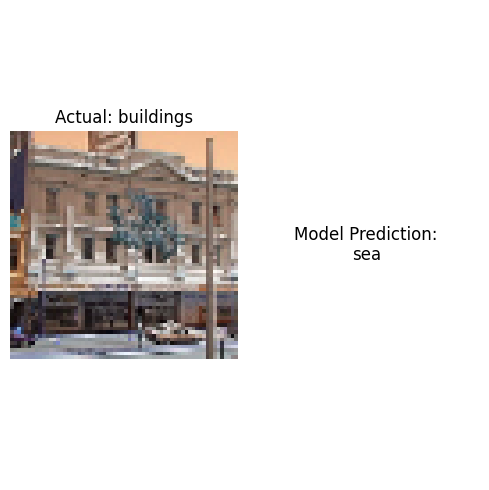

<Figure size 600x300 with 0 Axes>

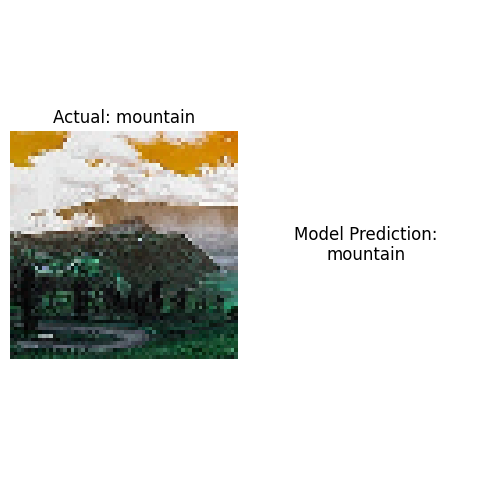

<Figure size 600x300 with 0 Axes>

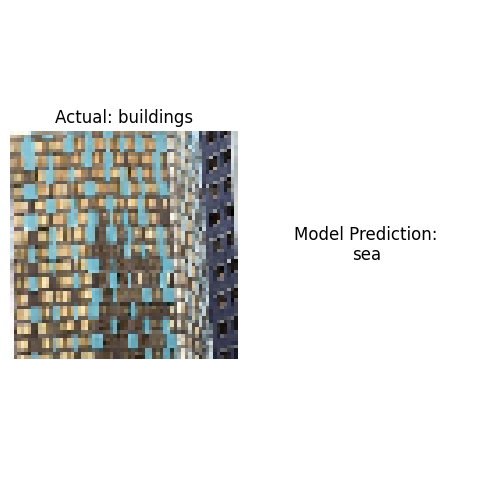

<Figure size 600x300 with 0 Axes>

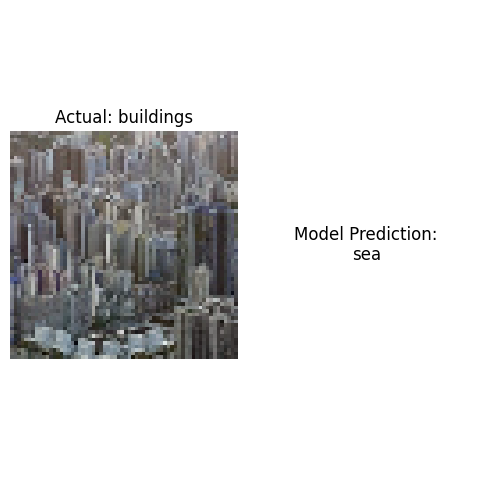

<Figure size 600x300 with 0 Axes>

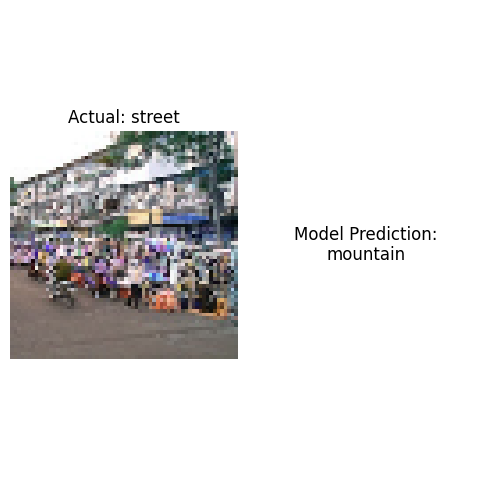

<Figure size 600x300 with 0 Axes>

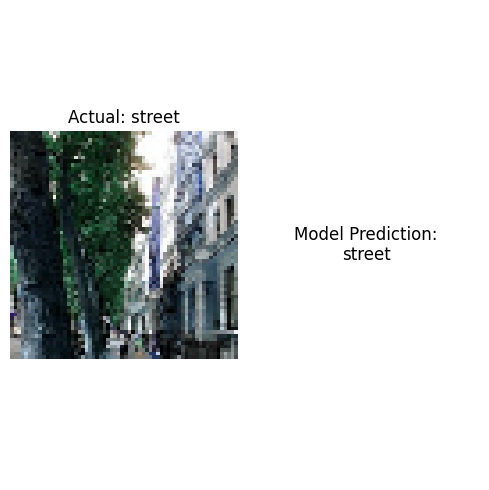

<Figure size 600x300 with 0 Axes>

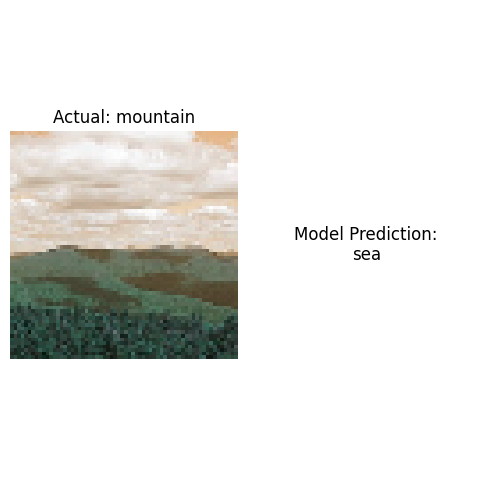

<Figure size 600x300 with 0 Axes>

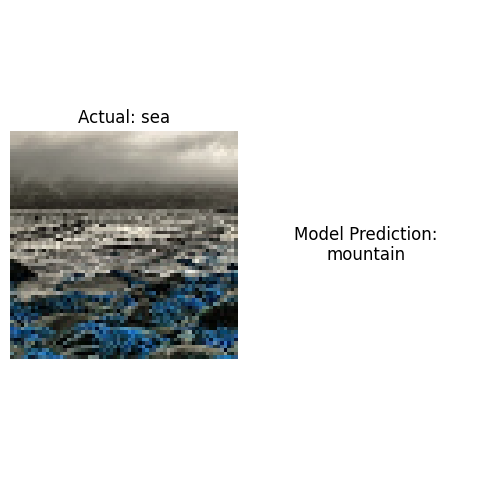

<Figure size 600x300 with 0 Axes>

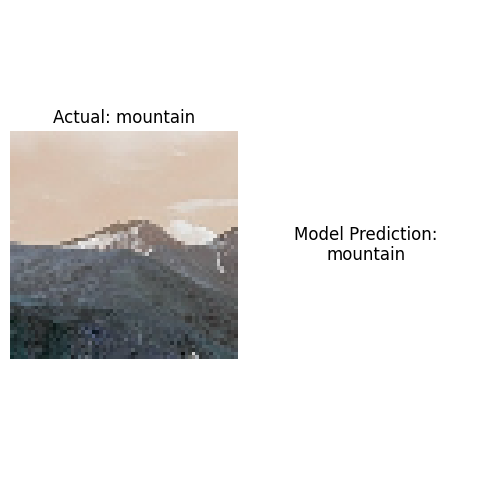

<Figure size 600x300 with 0 Axes>

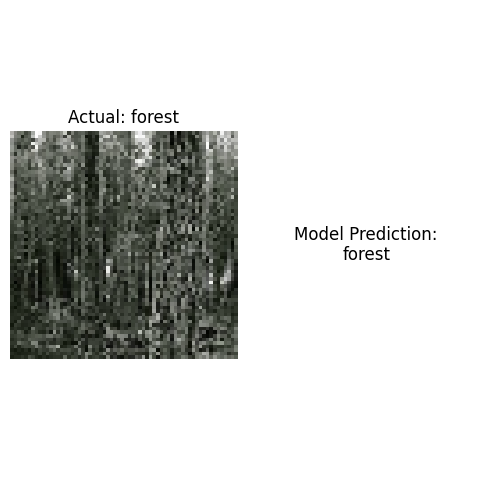

In [17]:

visualize_predictions(X_test, y_test, y_pred, categories)


In [19]:
from tensorflow import keras

# Define the model architecture (replace with your desired number of neurons and layers)
MLPmodel = keras.Sequential([
  keras.layers.Flatten(input_shape=(150, 150, 3)),  # Assuming RGB images
  keras.layers.Dense(128, activation='relu'),  # Hidden layer with 128 neurons and ReLU activation
  keras.layers.Dense(64, activation='relu'),  # Another hidden layer
  keras.layers.Dense(5, activation='softmax')  # Output layer with 5 neurons (one for each class) and softmax activation
])

# Compile the model (specifying optimizer, loss function, and metrics)
MLPmodel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\avoav\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
MLPmodel.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       8,640,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,648,709 (32.99 MB)

 Trainable params: 8,648,709 (32.99 MB)

 Non-trainable params: 0 (0.00 B)

In [21]:
MLPmodel.fit(features, one_hot_labels, epochs=5, batch_size=128, validation_split=0.2)

NameError: name 'features' is not defined

# logistic regression with grid search- find the best hyperparameters.

In [67]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
len(X_train)/5

1860.8

In [68]:

from sklearn.model_selection import GridSearchCV

# Define the hyperparameter grid
param_grid = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10],
    'logisticregression__solver': ['lbfgs', 'newton-cg', 'liblinear']
}

# Create the pipeline with LogisticRegression
pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, random_state=42))

# Create the GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)


In [71]:

def batch_train_predict(X, y, batch_size, model_class=LogisticRegression, **model_kwargs):
  """
  Trains a model on the data in batches and predicts on unseen data.

  Args:
      X: Training features.
      y: Training targets.
      batch_size: Size of data batches.
      model_class: The model class to use (e.g., LogisticRegression).
      model_kwargs: Keyword arguments to pass to the model constructor.

  Returns:
      y_pred: Predictions on unseen data.
  """
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = []

  for i in range(0, len(X_train), batch_size):
    batch_X = X_train[i:i+batch_size]
    batch_X_scaled = scaler.fit_transform(batch_X)
    X_train_scaled.append(batch_X_scaled)

  # Combine scaled batches into a single array
  X_train_scaled = np.concatenate(X_train_scaled, axis=0)

  model = model_class(**model_kwargs)
  model.fit(X_train_scaled, y_train)

  X_test_scaled = scaler.transform(X_test)
  y_pred = model.predict(X_test_scaled)
  return y_pred

# Call the function with your data, batch size, and model details
batch_size = 1860
y_pred = batch_train_predict(X, y, batch_size, model_class=LogisticRegression, max_iter=1000, random_state=42)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with batch processing: {accuracy:.2f}")

Accuracy with batch processing: 0.34


##  MLP model


In [22]:
data_directory = 'seg_train/seg_train'

In [23]:
test_data = 'seg_test/seg_test'

In [24]:
os.listdir(data_directory)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [25]:
os.listdir(test_data)

['buildings', 'forest', 'mountain', 'sea', 'street']

In [59]:
# According to Kaggle the original size if 150*150, therefore we want to keep it as is
data = tf.keras.utils.image_dataset_from_directory(data_directory, image_size = (150,150), batch_size=200)

Found 11630 files belonging to 5 classes.


In [60]:
test = tf.keras.utils.image_dataset_from_directory(test_data, image_size = (150,150), batch_size=200)

Found 2447 files belonging to 5 classes.


In [61]:
data_iterator = data.as_numpy_iterator()
test_iterator = test.as_numpy_iterator()

In [62]:
batch = data_iterator.next()

In [63]:
batch_test = test_iterator.next()

In [64]:
# where the first batch is our data and the second is the labels
len(batch),len(batch_test)

(2, 2)

In [65]:
batch[0].shape

(200, 150, 150, 3)

In [66]:
batch_test[0].shape

(200, 150, 150, 3)

In [67]:
batch[1]

array([3, 4, 4, 2, 3, 3, 1, 0, 2, 3, 3, 3, 2, 1, 4, 3, 1, 2, 3, 1, 1, 4,
       1, 4, 4, 0, 3, 4, 4, 2, 4, 4, 4, 0, 2, 0, 4, 4, 2, 0, 4, 3, 1, 3,
       3, 0, 3, 2, 1, 4, 0, 1, 1, 1, 4, 1, 3, 0, 4, 3, 1, 3, 2, 4, 1, 1,
       0, 0, 2, 4, 0, 4, 1, 0, 4, 3, 2, 3, 3, 2, 4, 1, 1, 4, 2, 3, 0, 2,
       0, 2, 1, 2, 3, 3, 1, 3, 1, 1, 2, 0, 0, 2, 2, 1, 2, 1, 3, 2, 2, 4,
       0, 2, 4, 2, 4, 2, 4, 4, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 1, 1, 1, 2,
       4, 4, 0, 1, 2, 1, 0, 1, 2, 0, 4, 4, 2, 4, 2, 1, 1, 3, 1, 2, 3, 3,
       3, 0, 4, 2, 1, 1, 2, 4, 1, 2, 0, 2, 0, 2, 4, 2, 2, 2, 2, 4, 0, 4,
       1, 3, 1, 3, 4, 4, 4, 3, 2, 3, 4, 3, 4, 1, 4, 1, 3, 1, 2, 4, 3, 3,
       2, 4])

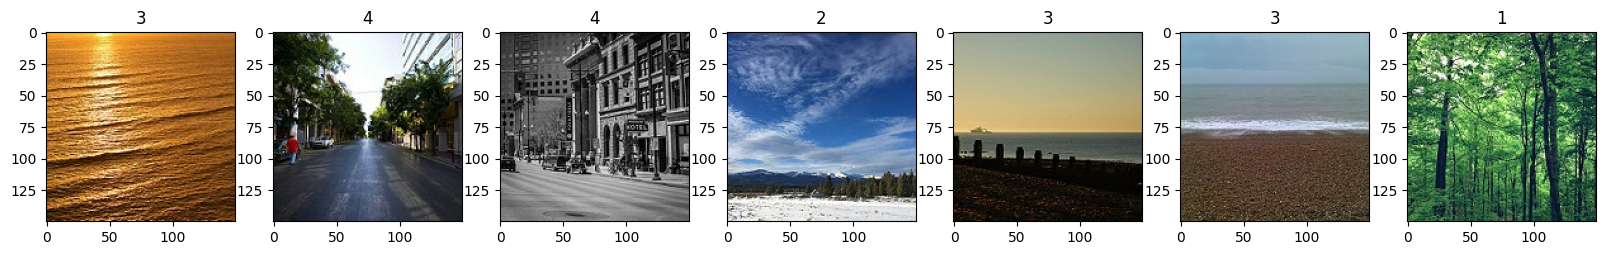

In [68]:
fig, ax = plt.subplots(ncols=7, figsize=(20,20))
for idx, img in enumerate(batch[0][:7]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

As we can see above the following numbers match the following catagories:

0. building
1. forest
2. glacier
3. mountain
4. sea
5. street

In [69]:
print("max:" , batch[0].max(), " and min: ", batch[0].min())

max: 255.0  and min:  0.0


In [70]:
data = data.map(lambda x, y: (x / 255.0, y))

In [71]:
test = test.map(lambda x, y: (x / 255.0, y))

In [72]:
data.as_numpy_iterator().next()[0].max(), data.as_numpy_iterator().next()[0].min()

(1.0, 0.0)

In [73]:
train_size = int(len(data)*0.8)
val_size = int(len(data)*0.2)

In [74]:
print(train_size, val_size)

47 11


In [75]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

In [76]:
# Number of batches * 32 images
len(train), len(val), len(test)

(47, 11, 13)

In [77]:
input_shape = (150, 150, 3)
num_classes = 5  # Number of classes

In [78]:
features, labels = batch
one_hot_labels = tf.keras.utils.to_categorical(labels, num_classes=num_classes)

In [47]:
tf.debugging.check_numerics(features, "Data contains NaN or infinity values.")
tf.debugging.enable_check_numerics()


INFO:tensorflow:Enabled check-numerics callback in thread MainThread


In [82]:

# Define the MLP model
def create_mlp_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),  # For flattened images
        tf.keras.layers.Dense(200, activation='relu'),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(5, activation='softmax')  # 5 output neurons for 5 classes
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Create the MLP model
MLPmodel = create_mlp_model(input_shape)

# Train the model (error handling removed for clarity)
MLPmodel.fit(features, one_hot_labels, epochs=20, batch_size=200, validation_split=0.2)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.2125 - loss: 86.2206 - val_accuracy: 0.1500 - val_loss: 12565.7471
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2188 - loss: 11169.3477 - val_accuracy: 0.3000 - val_loss: 14804.3096
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2188 - loss: 15382.0703 - val_accuracy: 0.2000 - val_loss: 7913.3955
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2250 - loss: 8286.8887 - val_accuracy: 0.0750 - val_loss: 7432.1650
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1375 - loss: 8109.3438 - val_accuracy: 0.2750 - val_loss: 8162.8735
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 9192.0762 - val_accuracy: 0.2750 - val_loss: 6455.9326
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2000 - loss: 7424.5498 - val_accuracy: 0.2000 - val_loss: 7144.8345
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2250 - loss: 7832.1670 - val_accur

In [99]:

def create_improved_mlp_model(input_shape, num_classes=5):
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape=input_shape),  # For flattened images
        tf.keras.layers.Normalization(),  # Add normalization for consistent scale
        tf.keras.layers.Dense(256, activation='relu'),  # Experiment with neurons and activation,
        tf.keras.layers.Dropout(0.44),  # Add dropout to prevent overfitting
        tf.keras.layers.Dense(150, activation='relu'),  # Experiment with architecture
        tf.keras.layers.Dense(num_classes, activation='softmax')  # Output layer
    ])

    model.compile(optimizer='adam',  # Experiment with optimizers
                  loss='categorical_crossentropy' if num_classes > 2 else 'mse',
                  metrics=['accuracy' if num_classes > 2 else 'mse'])  # Use appropriate metrics

    return model

In [100]:

# Create the MLP model
ImMLPmodel = create_improved_mlp_model(input_shape)

# Train the model (error handling removed for clarity)
ImMLPmodel.fit(features, one_hot_labels, epochs=20, batch_size=200, validation_split=0.2)


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - accuracy: 0.1750 - loss: 225.9783 - val_accuracy: 0.1500 - val_loss: 16739.3906
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2188 - loss: 16243.4062 - val_accuracy: 0.3000 - val_loss: 8655.6719
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2188 - loss: 9263.3730 - val_accuracy: 0.2000 - val_loss: 8286.2637
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2188 - loss: 10441.0225 - val_accuracy: 0.2750 - val_loss: 3970.0195
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2375 - loss: 7244.6226 - val_accuracy: 0.2750 - val_loss: 1951.5020
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.2250 - loss: 5271.7881 - val_accuracy: 0.0750 - val_loss: 4062.3269
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.1688 - loss: 6290.2510 - val_accuracy: 0.2000 - val_loss: 2360.0320
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.2000 - loss: 4567.3804 - val_accur

In [85]:
ImMLPmodel.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)                 │ (None, 67500)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ normalization_5 (Normalization)      │ (None, 67500)               │         135,001 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_33 (Dense)                     │ (None, 256)                 │      17,280,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_34 (Dense)                     │ (None, 150)                 │          38,550 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 5)                   │             755 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,093,686 (198.72 MB)

 Trainable params: 17,319,561 (66.07 MB)

 Non-trainable params: 135,001 (527.35 KB)

 Optimizer params: 34,639,124 (132.14 MB)

In [129]:
predictions = MLPmodel.predict(test_features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step


In [130]:
len(predictions)

200

In [131]:
test_features , test_labels = batch_test

In [133]:
# Calculate accuracy (assuming test_labels are one-hot encoded)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictions.argmax(axis=1))

print('Accuracy MLP model:', accuracy)

Accuracy MLP model: 0.41


In [136]:
predictionsI = ImMLPmodel.predict(test_features)

7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 235ms/step


In [137]:
# Calculate accuracy (assuming test_labels are one-hot encoded)
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(test_labels, predictionsI.argmax(axis=1))

print('Accuracy improved MLP model:', accuracy)

Accuracy improved MLP model: 0.32


Despite attempts to make the model better, there was no improvement. As we continued training, we noticed NaN gradients, indicating our current approach isn't right for this classification task. It's clear we need to try a different method. We might consider using more advanced models, adjusting settings, or changing the neural network structure to handle the complexities of image classification better.